# Récupérer des données mesurées par un arduino avec Python


### Importation des "libraries" utiles :

In [1]:
%matplotlib notebook
#pour utiliser un backend graphique adapté au notebook

import numpy as np
import matplotlib.pyplot as plt
import time
import serial #non installé par défaut dans Anaconda, s'installe avec la commande "conda install pyserial" ou "pip install pyserial"

### Création de la fonction qui permet de récupérer les données envoyées par l'Arduino sur le port série :

In [2]:
def mesure_arduino(portserie,nb_donnees=1,nb_mesures=1,ferme_port=True):
    '''
    Fonction qui permet de récupérer sur le port série des données envoyées par un Arduino.
    
    Les données envoyées par l'Arduino doivent être la sous la forme suivante :
        - un "point de mesure" est constitué de N valeurs séparées par une tabulation (\t)
        - chaque "point de mesure" est séparé du précédent par un saut de ligne (\n)
    
    Paramètres
    ----------
    portserie : Objet "port série" renvoyé par serial.Serial
        Le port série sur lequel l'Arduino envoie les données qu'on veut récupérer.
    nb_donnees : Nombre, optionnel
        Nombre N de valeurs envoyées par l'Arduino à chaque "point de mesure". Par défaut = 1.
    nb_mesures : Nombre, optionnel
        Nombre de "points de mesures" successifs qu'on veut enregistrer. Par défaut = 1.
    ferme_port : booléen, optionnel
        Est-ce qu'on ferme la connexion avec le port série à la fin de la mesure ? Par défaut = True.

    Renvoie
    -------
    data : Array numpy de dimension nb_mesures x nb_donnees (contient l'intégralité des points de mesures demandés).

    '''
    
    if not(portserie.isOpen()): #on vérifie si le port série est déjà ouvert ou pas
        portserie.open()
        print('Ouverture du port série')
        time.sleep(0.1)#pause de 0.1 s pour laisser le temps à la connexion port série de s'établir
    
    data=np.nan*np.ones((nb_mesures,nb_donnees))  #on crée un tableau de données de la bonne dimension (pour l'instant rempli de NaN)
    
    portserie.reset_input_buffer() #élimine tout ce qui peut avoir été envoyé sur le port série avant de commencer les mesures
    
    try :
        print(portserie.readline()) #on affiche la première ligne de données envoyée par l'arduino (juste pour vérifier que tout va bien)
    except:
        print('Problème de réception des données, vérifiez la connexino avec l\'Arduino.')
        return
    
    #La mesure peut être intérrompue en appuyant sur ctrl + C s'il y a un problème (par exemple si on se rend compte que ça prend beaucoup plus de temps que prévu)
    for i_mes in range(nb_mesures) :
        try:
            data_byte=portserie.readline() #on récupère les données envoyées ligne par ligne
            data_string=data_byte.decode('ascii') #on transforme les données en chaîne de caractère
            data[i_mes,0:(nb_donnees+1)]=np.fromstring(data_string, dtype=float, sep="\t") #on remplit progressivement le tableau "data" avec les données reçues
            
            if (i_mes+1) % (nb_mesures/10) == 0 :
                print("Mesure {} / {} ".format(i_mes+1,nb_mesures)) #permet d'afficher une "barre de progression" de la mesure
        
        except KeyboardInterrupt:
            print("Vous avez interrompu la lecture") #ce qui s'affiche si on arrête la boucle en appuyant sur ctrl + C
            time.sleep(0.1)
            break

    print('Fin de l\'acquisition')
    
    if ferme_port:
        portserie.close() #on arrête la connexion avec l'arduino via le port série
        print('Fermeture du port série')
    
    return data

### Choix des paramètres (modifiez ces valeurs pour correspondre à votre situation) :

In [3]:
ser = serial.Serial()
ser.baudrate = 250000 #on définit le baudrate (doit être le même que celui dans le sketch arduino)
ser.port = 'COM3' #on définit sur quel port série l'arduino est branché

nb_donnees=2 #nombre de valeurs que l'arduino renvoie sur chaque ligne (pour cet exemple : le temps et la tension)
nb_mesures = 10000 #nombre de points de mesures que l'on veut mesurer

### Récupération des données envoyées par l'arduino sur le port série :
Ici pour la démonstration, on mesure le signal créé par la fonction [tone](https://www.arduino.cc/reference/en/language/functions/advanced-io/tone/) d'un autre Arduino, avec une fréquence de 245 Hz. On s'attend donc à mesurer un signal créneau, de fréquence 245 Hz.

In [4]:

data = mesure_arduino(ser,nb_donnees,nb_mesures)


Ouverture du port série
b"Debut de l'acquisition\r\n"
Mesure 1000 / 10000 
Mesure 2000 / 10000 
Mesure 3000 / 10000 
Mesure 4000 / 10000 
Mesure 5000 / 10000 
Mesure 6000 / 10000 
Mesure 7000 / 10000 
Mesure 8000 / 10000 
Mesure 9000 / 10000 
Mesure 10000 / 10000 
Fin de l'acquisition
Fermeture du port série


### On trace les données obtenues :
Ici le tableau ```data``` contient une colonne avec des temps de mesure (en µs), et une colonne avec des bits (entre 0 et 1023) qui correspondent à des V (entre 0 et 5 V).

<IPython.core.display.Javascript object>


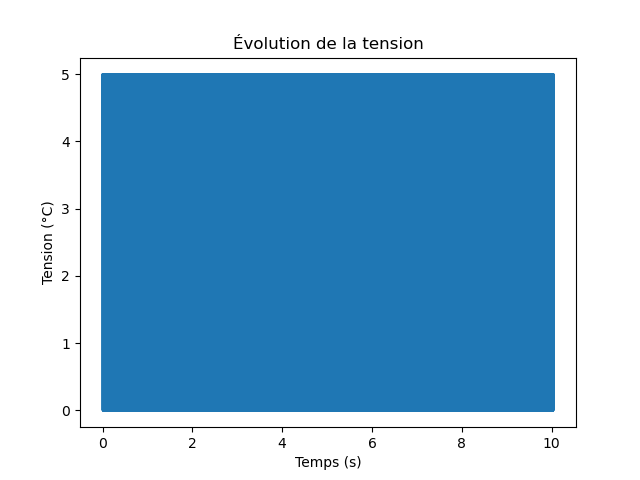

Text(0.5, 1.0, 'Évolution de la tension')

In [5]:
temps = (data[:,0]-data[0,0])/1e6 #on fixe t = 0 à la première mesure, et on convertit les µs en s
tension= data[:,1]/1024*5 #on convertit les bits en V (/1024*5)

plt.figure()
plt.plot(temps,tension)
plt.xlabel('Temps (s)')
plt.ylabel('Tension (°C)')
plt.title('Évolution de la tension')

Étant donné qu'ici on mesure un signal dont la fréquence est environ 250 Hz, on va zoomer un peu pour regarder le signal :

<IPython.core.display.Javascript object>


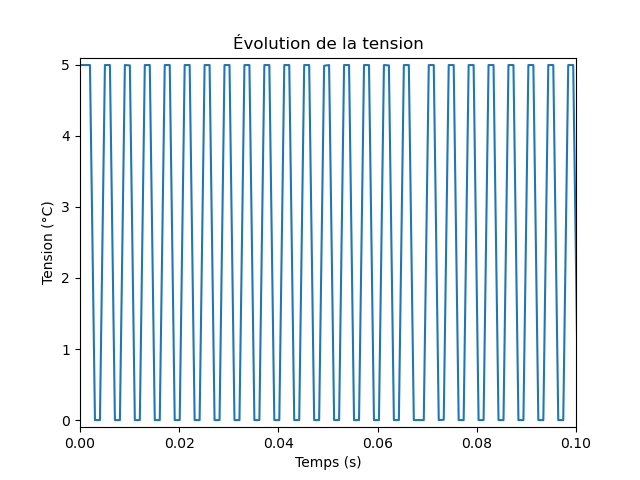

Text(0.5, 1.0, 'Évolution de la tension')

In [6]:
plt.figure()
plt.plot(temps,tension)
plt.axis([0,0.1,-0.1,5.1])
plt.xlabel('Temps (s)')
plt.ylabel('Tension (°C)')
plt.title('Évolution de la tension')

Ça ressemble bien à un créneau, de fréquence proche de 250 Hz (on compte un tout petit peu moins de 25 battements en 0.1 s).

#### Pour information :
La mesure peut être stopée en cours d'utilisation en appuyant sur le bouton "stop" à côté du bouton "Exécuter" dans le menu principal de Jupyter. Dans ce cas, la fonction renvoie quand même le tableau des points qui ont été mesurés jusqu'à l'interruption de la mesure (il est donc possible d'interrompre une mesure avant la fin sans perdre les données déjà enregistrées).

### On peut également vérifier que la fréquence d'acquisition était bien constante lors de la mesure :
Pour chaque point de mesure, on calcule la différence le time-stamp de ce point, et du point suivant, afin de vérifier que le délais entre deux mesures est bien constant (et proche de 1 ms).

<IPython.core.display.Javascript object>


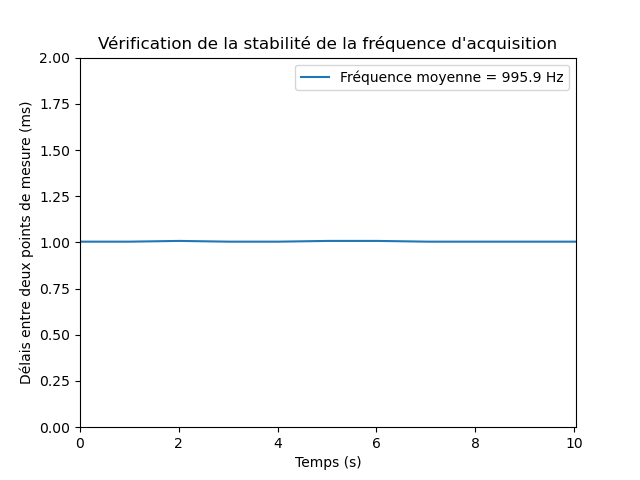

In [7]:
plt.figure()
plt.plot(temps[:-1]*1e3,np.diff(temps)*1e3,label='Fréquence moyenne = {:.4} Hz'.format(1/np.nanmean(np.diff(temps))))
plt.axis([np.nanmin(temps),np.nanmax(temps),0,2])
plt.xlabel('Temps (s)')
plt.ylabel('Délais entre deux points de mesure (ms)')
plt.title('Vérification de la stabilité de la fréquence d\'acquisition')
plt.legend()

On constate qu'on n'est pas pile à 1kHz d'échantillonnage, mais on n'est pas très loin (et la fréquence d'acquisition a l'air stable dans le temps).